<a href="https://colab.research.google.com/github/C242-PS253-Capstone-Team/ML_Face_Shape_Recognition/blob/rifal/ML_Model_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Library

In [ ]:
pip install --upgrade tensorflow keras

In [ ]:
pip install mtcnn

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import re
import shutil
import cv2
import tensorflow as tf
import tensorflow_datasets as tfds
import keras
import mtcnn

from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom, RandomContrast, RandomTranslation, RandomBrightness
from keras.utils import plot_model
from matplotlib import pyplot as plt
from mtcnn import MTCNN
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from tensorflow.keras.applications.mobilenet import preprocess_input

# EDA

#### Load Dataset

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
train_dr = '/content/drive/MyDrive/Dataset_Capstone/extracted_faces/train'
val_dr = '/content/drive/MyDrive/Dataset_Capstone/extracted_faces/test'

In [104]:
# Mengurutkan folder di training directory
train_folders = [folder for folder in class_names if folder in os.listdir(train_dr)]

# Mengurutkan folder di validation directory
val_folders = [folder for folder in class_names if folder in os.listdir(val_dr)]

In [106]:
print("Training directory contents:", train_folders)
print("Validation directory contents:", val_folders)

Training directory contents: ['Oblong', 'Heart', 'Round', 'Square', 'Oval']
Validation directory contents: ['Oblong', 'Heart', 'Round', 'Square', 'Oval']


In [ ]:
# Inisialisasi detektor MTCNN
detector = MTCNN()

def extract_face(img, target_size=(224,224)):
    '''this function extracts the face from different images by
    1) finds the facial bounding box
    2) slightly expands top & bottom boundaries to include the whole face
    3) crop into a square shape
    4) resize to target image size for modelling
    5) if the facial bounding box in step 1 is not found, image will be cropped & resized to 224x224 square'''

    # 1. deteksi wajah pada gambar
    results = detector.detect_faces(img)
    if results == []:  # jika wajah tidak terdeteksi, crop & resize dengan mempertahankan rasio aspek
        new_face = crop_and_resize(img, target_w=224, target_h=224)
    else:
        x1, y1, width, height = results[0]['box']
        x2, y2 = x1 + width, y1 + height
        face = img[y1:y2, x1:x2]  # wajah dari bounding box sebelum ekspansi bbox

        # 2. memperbesar bagian atas dan bawah bounding box sebanyak 10 pixel untuk memastikan seluruh wajah terekstrak
        adj_h = 10
        new_y1 = max(0, y1 - adj_h)
        new_y2 = min(img.shape[0], y1 + height + adj_h)
        new_height = new_y2 - new_y1

        # 3. crop gambar menjadi bentuk persegi
        adj_w = int((new_height - width) / 2)
        new_x1 = max(0, x1 - adj_w)
        new_x2 = min(img.shape[1], x2 + adj_w)
        new_face = img[new_y1:new_y2, new_x1:new_x2]  # crop wajah ke bentuk persegi

    # 4. resize gambar ke ukuran target
    sqr_img = cv2.resize(new_face, target_size)
    return sqr_img

In [ ]:
def process_and_save_images_optimized(class_path, output_class_path, batch_size=50):
    import gc
    files = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    total_files = len(files)

    for i in range(0, total_files, batch_size):
        batch_files = files[i:i + batch_size]
        for item in batch_files:
            item_path = os.path.join(class_path, item)
            extracted_face = None
            try:
                img = cv2.imread(item_path, cv2.IMREAD_REDUCED_COLOR_2)  # Optimized reading
                img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                extracted_face = extract_face(img_rgb)

                if extracted_face is not None:
                    output_file_path = os.path.join(output_class_path, item)
                    cv2.imwrite(output_file_path, cv2.cvtColor(extracted_face, cv2.COLOR_RGB2BGR))
                    print(f"Successfully processed and saved: {output_file_path}")
                else:
                    print(f"Face not detected in: {item_path}")
            except Exception as e:
                print(f"Error processing image {item_path}: {e}")
            finally:
                if extracted_face is not None:
                    del img, extracted_face  # Free memory
                gc.collect()

        print(f"Processed batch {i // batch_size + 1}/{(total_files + batch_size - 1) // batch_size}")



# --- Cara menggunakan fungsi yang dimodifikasi ---
# Tentukan path dataset dan output
dataset_path = '/content/drive/MyDrive/Dataset_Capstone/Kaggle/combined_data/combined_train/Round'
output_path = '/content/drive/MyDrive/Dataset_Capstone/extracted_faces/train/Round'

# Ensure the output directory exists
if not os.path.exists(output_path):
    os.makedirs(output_path)

# Directly call process_and_save_images with the dataset path
process_and_save_images_optimized(dataset_path, output_path)

# Lakukan hal yang sama untuk dataset validation

In [107]:
# Menampilkan urutan folder
print("Urutan folder di dalam", train_dr_new + ":")
for i, folder_name in enumerate(train_folders):
  print(f"{i+1}. {folder_name}")

# Menampilkan urutan folder
print("Urutan folder di dalam", val_dr_new + ":")
for i, folder_name in enumerate(val_folders):
  print(f"{i+1}. {folder_name}")

Urutan folder di dalam /content/drive/MyDrive/Dataset_Capstone/extracted_faces/train:
1. Oblong
2. Heart
3. Round
4. Square
5. Oval
Urutan folder di dalam /content/drive/MyDrive/Dataset_Capstone/extracted_faces/test:
1. Oblong
2. Heart
3. Round
4. Square
5. Oval


In [6]:
class_names = ['Oblong', 'Heart', 'Round', 'Square', 'Oval']

In [7]:
def create_datasets():
    train_ds = tf.keras.utils.image_dataset_from_directory(
        train_dr,
        seed=0,
        batch_size=32,
        label_mode='categorical',
        image_size=(224, 224),
    )

    validation_ds = tf.keras.utils.image_dataset_from_directory(
        val_dr,
        seed=0,
        batch_size=32,
        label_mode='categorical',
        image_size=(224, 224),
    )

    return train_ds, validation_ds

In [8]:
# Create datasets with or without data augmentation
train_ds, validation_ds = create_datasets()

Found 3996 files belonging to 5 classes.
Found 1010 files belonging to 5 classes.


In [9]:
IMG_SHAPE = (224, 224, 3)

base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=IMG_SHAPE
)

tuning_layer_name = 'block_15_expand'
tuning_layer = base_model.get_layer(tuning_layer_name)
tuning_index = base_model.layers.index(tuning_layer)

# Membekukan semua layer sebelum tuning_layer
for layer in base_model.layers[:tuning_index]:
    layer.trainable = False

# Layer augmentasi
data_augmentation = tf.keras.Sequential([
    Rescaling(1./255),
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.1),
    RandomZoom(0.1),
    RandomContrast(0.3),
    RandomTranslation(0.1, 0.1),
], name='data_augmentation')

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [20]:
model = Sequential([
    data_augmentation,
    base_model,
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(len(class_names), activation='softmax')
])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)       │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 62720)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │       4,014,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,272,453 (23.93 MB)

 Trainable params: 5,220,549 (19.91 MB)

 Non-trainable params: 1,051,904 (4.01 MB)

In [21]:
learning_rate = 0.0001

model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    metrics=['accuracy']
)

class EarlyStoppingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs['accuracy']>0.85:
            self.model.stop_training = True
            print("\nReached 85% accuracy so cancelling training!")

early_stopping_callback = EarlyStoppingCallback()

In [22]:
EPOCH = 50
BATCH_SIZE = 32

history = model.fit(
    train_ds,
    epochs=EPOCH,
    verbose=1,
    validation_data=validation_ds,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping_callback]
)

Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 437s 3s/step - accuracy: 0.2169 - loss: 1.8911 - val_accuracy: 0.2416 - val_loss: 1.6174
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 426s 3s/step - accuracy: 0.2191 - loss: 1.5927 - val_accuracy: 0.2743 - val_loss: 1.6013
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 447s 3s/step - accuracy: 0.2656 - loss: 1.5636 - val_accuracy: 0.3238 - val_loss: 1.6097
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 439s 3s/step - accuracy: 0.2695 - loss: 1.5509 - val_accuracy: 0.2842 - val_loss: 1.6843
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 443s 3s/step - accuracy: 0.3157 - loss: 1.5138 - val_accuracy: 0.2861 - val_loss: 1.8867
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 406s 3s/step - accuracy: 0.3389 - loss: 1.4506 - val_accuracy: 0.2297 - val_loss: 2.5316
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 416s 3s/step - accuracy: 0.3626 - loss: 1.4156 - val_accuracy: 0.3059 - val_loss: 1.9763
Epoch 8/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 423s 3s/step - accuracy: 0.4064 - loss: 1.3599 - val_accu

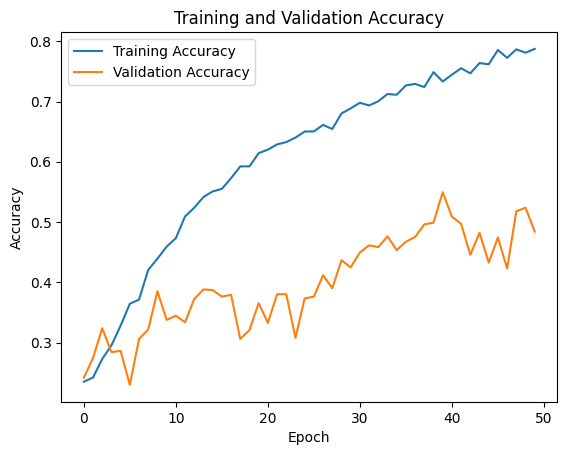

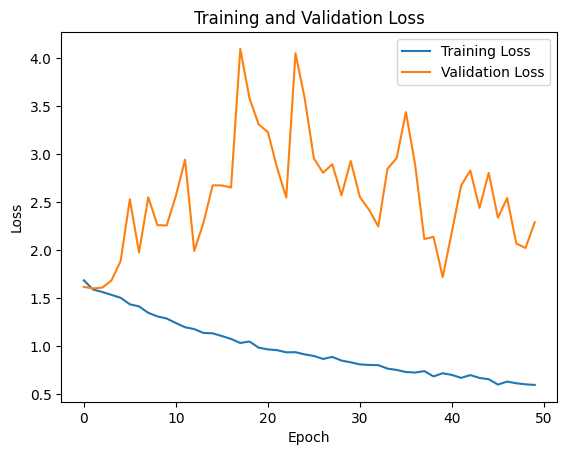

In [23]:
# Visualisasi akurasi
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

# Visualisasi loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.show()

## PREDICT

In [24]:
def predict_and_compare(testing_ds, model, class_names): # Add class_names as an argument
  """
  Memprediksi bentuk wajah dari gambar di testing_ds dan membandingkannya dengan label.

  Args:
    testing_ds: Dataset testing TensorFlow.
    model: Model TensorFlow yang sudah dilatih.
    class_names: List of class names. # Document the new argument

  Returns:
    List yang berisi tuple (image_path, predicted_label, true_label, is_correct).
  """

  results = []
  for image_batch, label_batch in testing_ds.as_numpy_iterator():
    for image, label in zip(image_batch, label_batch):
      # Prediksi
      image = tf.expand_dims(image, 0)
      predictions = model.predict(image)
      predicted_class_index = np.argmax(predictions[0])
      predicted_label = class_names[predicted_class_index] # Use class_names argument

      # Label sebenarnya
      true_label = class_names[np.argmax(label)] # Use class_names argument

      # Perbandingan
      is_correct = predicted_label == true_label

      # Simpan hasil
      results.append((image, predicted_label, true_label, is_correct))

  return results

class_names_test = sorted(os.listdir(val_dr_new))

results = predict_and_compare(testing_ds, model, class_names)

# Tampilkan beberapa hasil
for image, predicted_label, true_label, is_correct in results[:10]:  # Tampilkan 10 hasil pertama
  print(f"Predicted: {predicted_label}, True: {true_label}, Correct: {is_correct}")

NameError: name 'val_dr_new' is not defined

In [25]:
def predict_face_shape(image_path, class_names):
    """
    Memprediksi bentuk wajah dari gambar.
    """
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    img = img / 255.0
    img = np.expand_dims(img, axis=0).astype(np.float32)

    predictions = model.predict(img)  # Gunakan model yang sudah ada
    predicted_class_index = np.argmax(predictions[0])

    return class_names[predicted_class_index]

# Path ke folder gambar di Google Drive
folder_path = '/content/drive/MyDrive/Dataset_Capstone/extracted_faces/test/Heart'

# List nama kelas bentuk wajah - ORDER MUST MATCH TRAINING DATA
class_names = ['Oblong', 'Heart', 'Round', 'Square', 'Oval']

# Loop dan Prediksi
for filename in os.listdir(folder_path):
  if filename.endswith(('.jpg', '.jpeg', '.png')):
    image_path = os.path.join(folder_path, filename)
    predicted_shape = predict_face_shape(image_path, class_names)
    print(f"Gambar: {filename}, Bentuk Wajah: {predicted_shape}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Gambar: heart (141).jpg, Bentuk Wajah: Heart
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
Gambar: heart (136).jpg, Bentuk Wajah: Heart
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
Gambar: heart (135).jpg, Bentuk Wajah: Heart
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Gambar: heart (123).jpg, Bentuk Wajah: Heart
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
Gambar: heart (156).jpg, Bentuk Wajah: Heart
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Gambar: heart (102).jpg, Bentuk Wajah: Heart
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Gambar: heart (137).jpg, Bentuk Wajah: Heart
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Gambar: heart (101).jpg, Bentuk Wajah: Heart
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
Gambar: heart (13).jpg, Bentuk Wajah: Heart
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
Gambar: heart (138).jpg, Bentuk Wajah: Heart
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
Gambar: heart (139).jpg, Bentuk Wajah: Heart
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
Gambar: heart (140).jpg, Bentuk Wajah: Heart
1/1

In [26]:
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Dapatkan prediksi untuk data testing
y_pred = model.predict(validation_ds)
y_pred = np.argmax(y_pred, axis=1)

# Dapatkan label sebenarnya untuk data testing
y_true = np.concatenate([y for x, y in validation_ds], axis=0)
y_true = np.argmax(y_true, axis=1)

# Hitung Presisi, Recall dan F1-score untuk setiap kelas
f1_scores = f1_score(y_true, y_pred, average=None)
precision_scores = precision_score(y_true, y_pred, average=None)
recall_scores = recall_score(y_true, y_pred, average=None)

32/32 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step


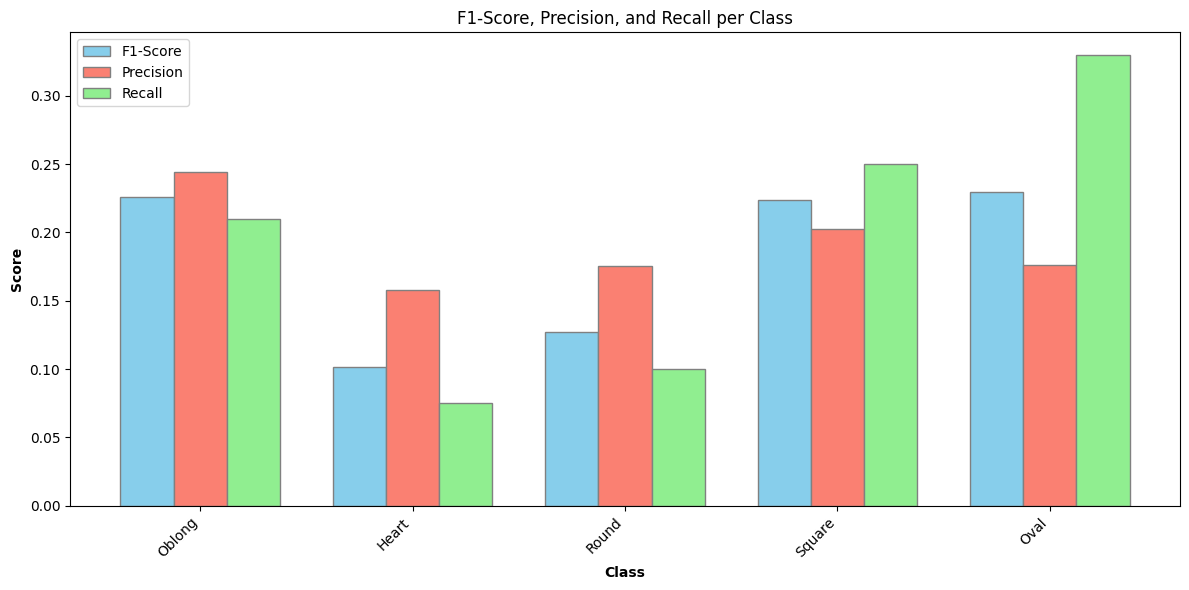

In [27]:
   # Lebar bar
   barWidth = 0.25

   # Posisi bar
   r1 = np.arange(len(class_names))
   r2 = [x + barWidth for x in r1]
   r3 = [x + barWidth for x in r2]

   # Buat bar chart
   plt.figure(figsize=(12, 6))  # Sesuaikan ukuran jika perlu
   plt.bar(r1, f1_scores, color='skyblue', width=barWidth, edgecolor='grey', label='F1-Score')
   plt.bar(r2, precision_scores, color='salmon', width=barWidth, edgecolor='grey', label='Precision')
   plt.bar(r3, recall_scores, color='lightgreen', width=barWidth, edgecolor='grey', label='Recall')

   # Tambahkan label dan judul
   plt.title('F1-Score, Precision, and Recall per Class')
   plt.xlabel('Class', fontweight='bold')
   plt.ylabel('Score', fontweight='bold')
   plt.xticks([r + barWidth for r in range(len(class_names))], class_names, rotation=45, ha='right')
   plt.legend()
   plt.tight_layout()
   plt.show()

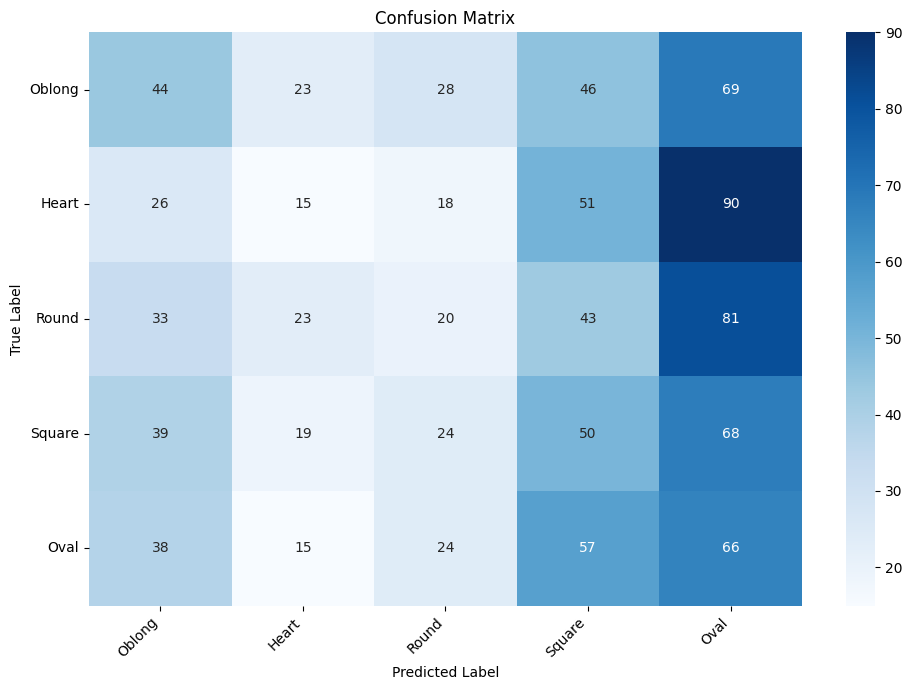

In [29]:
# Hitung confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Visualisasikan confusion matrix menggunakan seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45, ha='right')  # Rotasi label sumbu x agar mudah dibaca
plt.yticks(rotation=0)  # Rotasi label sumbu y agar mudah dibaca (opsional)
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd

# Create a pandas DataFrame from the confusion matrix
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)

# Display the DataFrame as a table
print(df_cm)

        Oblong  Heart  Round  Square  Oval
Oblong     174      1      4       0    31
Heart       84     58      3       1    54
Round       49      4     89      28    30
Square      47      2      5      51    95
Oval         9      2      6      27   156


In [ ]:
model.save('/content/drive/MyDrive/face_shape_classifier.h5')

## Convert to tfLite

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('/content/drive/MyDrive/Model_Capstone/face_shape_classifier.tflite', 'wb') as f:
    f.write(tflite_model)